# Probabilistic Forecasting: Global Models

Skforecast allow to apply all its implementd probabilistic forecasting methods (bootsraping, quantile regression and conformal prediction) to global models. This means that the model is trained with all the available time series and the forecast is made for all the time series.

For detailed information about the available probabilistic forecasting methods, see the following user guides:

- [Probabilistic forecasting: Bootstraping](https://skforecast.org/latest/user_guides/probabilistic-forecasting-bootstrapped-residuals.html)

- [Probabilistic forecasting: Quantile regression](https://skforecast.org/latest/user_guides/probabilistic-forecasting-quantile-regression.html)

- [Probabilistic forecasting: Conformal prediction](https://skforecast.org/latest/user_guides/probabilistic-forecasting-conformal-prediction.html)

## Libraries and data

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data
# ==============================================================================
data = fetch_dataset(name="ett_m2_extended")
data = data.resample(rule="1h", closed="left", label="right").mean()
data.head(2)

ett_m2_extended
---------------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL). Additional variables are created based on calendar
information (year, month, week, day of the week, and hour). These variables have
been encoded using the cyclical encoding technique (sin and cos transformations)
to preserve the cyclical nature of the data.
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,,,,,,,
2016-07-01 01:00:00,38.784501,10.88975,34.753500,8.551,4.12575,1.2605,37.83825,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.000000,1.000000
2016-07-01 02:00:00,36.041249,9.44475,32.696001,7.137,3.59025,0.6290,36.84925,2016.0,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.258819,0.965926


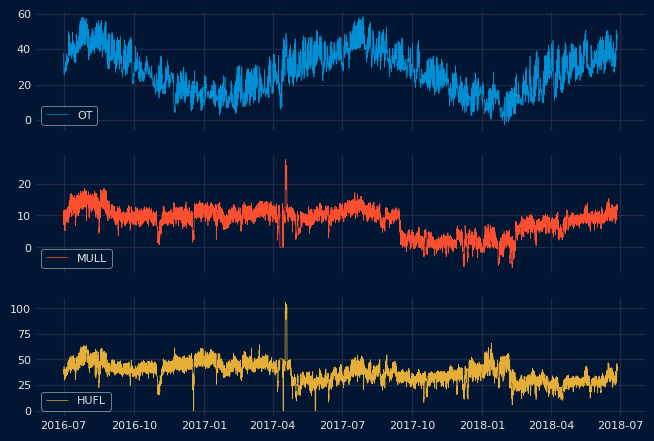

In [3]:
# Plot time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
series = ['OT', 'MULL', 'HUFL']
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)

In [4]:
data['MULL'] = data['OT']
data['HUFL'] = data['OT']

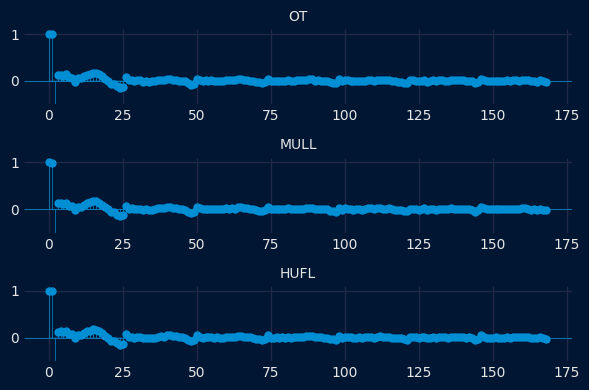

In [5]:
# Partial autocorrelation values and plots
# ==============================================================================
n_lags = 24 * 7
pacf_df = []
fig, axs = plt.subplots(3, 1, figsize=(6, 4))
axs = axs.ravel()
for i, col in enumerate(series):
    pacf_values = pacf(data[col], nlags=n_lags)
    pacf_values = pd.DataFrame({
        'lag': range(1, len(pacf_values)),
        'value': pacf_values[1:],
        'value_abs': np.abs(pacf_values[1:]),
        'variable': col
    })
    pacf_df.append(pacf_values)
    
    plot_pacf(data[col], lags=n_lags, ax=axs[i])
    axs[i].set_title(col, fontsize=10)
    axs[i].set_ylim(-0.5, 1.1)

plt.tight_layout()

In [6]:
# Top n lags with highest absolute partial autocorrelation per variable
# ==============================================================================
n = 10
top_lags = set()
for pacf_values in pacf_df:
    variable = pacf_values['variable'].iloc[0]
    lags = pacf_values.nlargest(n, 'value_abs')['lag'].sort_values().tolist()
    top_lags.update(lags)
    print(f"{variable}: {lags}")

top_lags = list(top_lags)
print(f"\nAll lags: {top_lags}")

OT: [1, 2, 3, 6, 13, 14, 15, 16, 17, 24]
MULL: [1, 2, 3, 6, 13, 14, 15, 16, 17, 24]
HUFL: [1, 2, 3, 6, 13, 14, 15, 16, 17, 24]

All lags: [1, 2, 3, 6, 13, 14, 15, 16, 17, 24]


The target series exhibit similar dynamics with several lagged correlations that can be used as predictors.

In [7]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-8-01 23:59:00'
end_validation = '2018-04-03 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 01:00:00 --- 2017-08-01 23:00:00  (n=9527)
Dates validacion : 2017-08-02 00:00:00 --- 2018-04-03 23:00:00  (n=5880)
Dates test       : 2018-04-04 00:00:00 --- 2018-06-26 20:00:00  (n=2013)


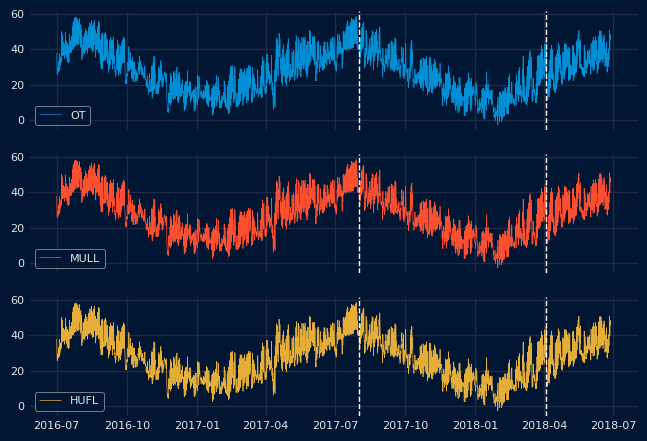

In [8]:
# Plot partitions
# ==============================================================================
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
for i, col in enumerate(series):
    axs[i].plot(data[col], label=col, color=colors[i])
    axs[i].legend(loc='lower left', fontsize=8)
    axs[i].tick_params(axis='both', labelsize=8)
    axs[i].axvline(pd.to_datetime(end_train), color='white', linestyle='--', linewidth=1)  # End train
    axs[i].axvline(pd.to_datetime(end_validation), color='white', linestyle='--', linewidth=1)  # End validation

In [9]:
# Create forecaster
# ==============================================================================
exog_features = [
    'year', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_of_week_sin',
    'day_of_week_cos', 'hour_sin', 'hour_cos'
]

params = {
    "n_estimators": 500,
    "learning_rate": 0.026,
    "max_depth": 7
}
window_features = RollingFeatures(stats=["mean", "min", "max"], window_sizes=24)
forecaster = ForecasterRecursiveMultiSeries(
                 #regressor          = LGBMRegressor(random_state=15926, verbose=-1),
                 regressor          = Ridge(random_state=15926),
                 lags               = top_lags,
                 encoding           = 'ordinal',
                 transformer_series = StandardScaler(),
                 transformer_exog   = StandardScaler(),
                 differentiation     = 1,
                 window_features    = window_features,
                 binner_kwargs      = {'n_bins': 10}
             )

In [10]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_train, :]),
         steps              = 24,  # all hours of next day
         differentiation    = 1,
     )

metric_val, predictions_val = backtesting_forecaster_multiseries(
                                  forecaster    = forecaster,
                                  series        = data.loc[:end_validation, series],
                                  exog          = data.loc[:end_validation, exog_features],
                                  cv            = cv,
                                  metric        = 'mean_absolute_error',
                                  n_jobs        = 'auto',
                                  verbose       = False,
                                  show_progress = True
                              )

  0%|          | 0/245 [00:00<?, ?it/s]

/home/ubuntu/anaconda3/envs/skforecast_15_py12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4063) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/ubuntu/anaconda3/envs/skforecast_15_py12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=4063) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


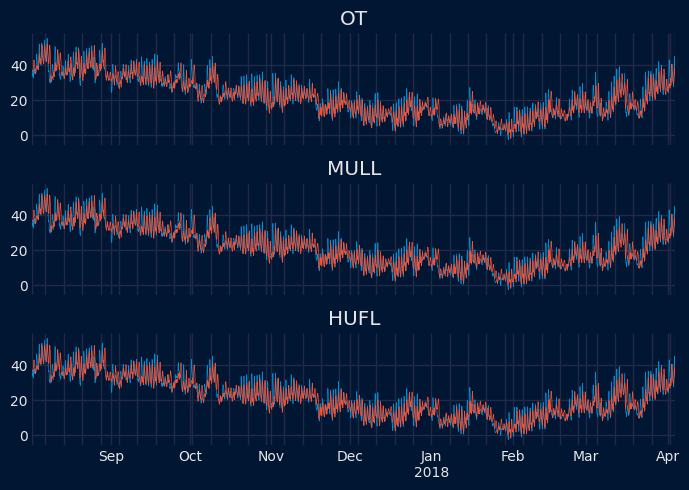

In [11]:
# Plot predictions on validation data
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True, sharey=False)
for i, level in enumerate(predictions_val['level'].unique()):
    predictions_val_level = predictions_val.loc[predictions_val['level'] == level, 'pred']
    data.loc[end_train:end_validation, level].plot(ax=axs[i], label='Real value')
    predictions_val_level.plot(ax=axs[i], label='prediction')
    axs[i].set_xlabel("")
    axs[i].set_title(level)
plt.tight_layout()

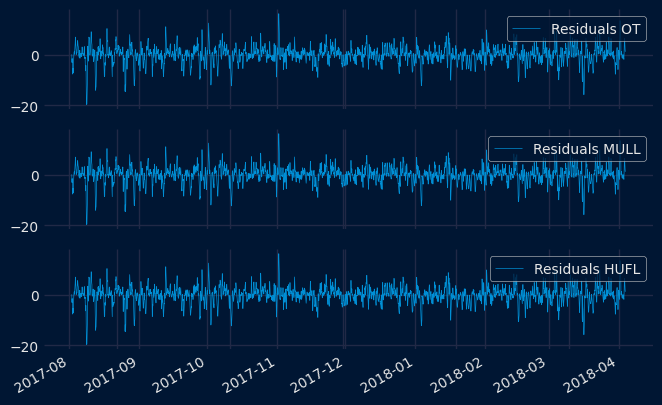

In [12]:
# Out-sample residuals distribution
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharex=True, sharey=False)
for i, level in enumerate(predictions_val["level"].unique()):
    residuals = (
        data.loc[predictions_val.index, level]
        - predictions_val.loc[predictions_val["level"] == level, "pred"]
    )
    residuals.plot(ax=axs[i], label=f"Residuals {level}")
    axs[i].legend(loc="upper right")

In [13]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.fit(
    series=data.loc[:end_train, series],
    exog=data.loc[:end_train, exog_features]
)
forecaster.set_out_sample_residuals(
    y_true = {k: data.loc[predictions_val.index.unique(), k] for k in series}, 
    y_pred = {k: v for k, v in predictions_val.groupby('level')['pred']}
)

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>


When storing new residuals in the forecaster, the residuals are binned according to the magnitude of the predictions they correspond to. Later, in the bootstrapping process, the residuals are sampled from the corresponding bin, ensuring that the distribution of the residuals is consistent with the predictions. This process allows for more accurate prediction intervals, as the residuals are more closely aligned with the predictions they correspond to resulting in better coverage with narrower intervals. For more information about how residuals are used in interval estimation visit <a href="https://skforecast.org/latest/user_guides/probabilistic-forecasting">Probabilistic forecasting: prediction intervals and prediction distribution</a>.

</div>

In [14]:
# Intervals of the residual bins (conditioned on predicted values) for each level
# ==============================================================================
from pprint import pprint
for k, v in forecaster.binner_intervals_.items():
    print(k)
    pprint(v)

HUFL
{0: (-0.32809373737174896, -0.09007196589850357),
 1: (-0.09007196589850357, -0.05898045458382154),
 2: (-0.05898045458382154, -0.04291737864751605),
 3: (-0.04291737864751605, -0.02985773397916314),
 4: (-0.02985773397916314, -0.016703185118908163),
 5: (-0.016703185118908163, -0.00010110305547423936),
 6: (-0.00010110305547423936, 0.0254237303504815),
 7: (0.0254237303504815, 0.06241635712378122),
 8: (0.06241635712378122, 0.122676254780225),
 9: (0.122676254780225, 0.5942018872054701)}
MULL
{0: (-0.32809373737174896, -0.09007196589850355),
 1: (-0.09007196589850355, -0.05898045458382154),
 2: (-0.05898045458382154, -0.04291737864751605),
 3: (-0.04291737864751605, -0.02985773397916314),
 4: (-0.02985773397916314, -0.016703185118908156),
 5: (-0.016703185118908156, -0.00010110305547423589),
 6: (-0.00010110305547423589, 0.025423730350481507),
 7: (0.025423730350481507, 0.06241635712378123),
 8: (0.06241635712378123, 0.122676254780225),
 9: (0.122676254780225, 0.5942018872054701)

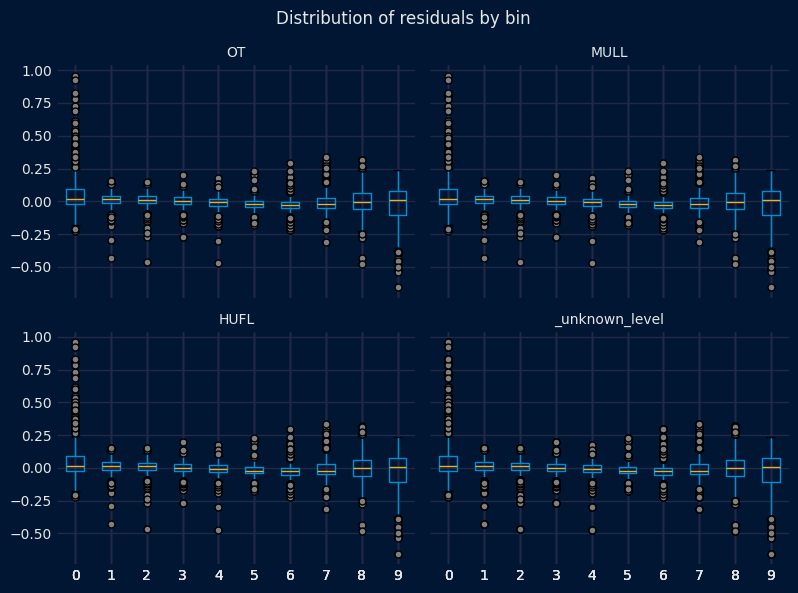

In [15]:
# Distribution of the residual by bin and level
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
axs = axs.ravel()
for i, level in enumerate(forecaster.out_sample_residuals_by_bin_):
    out_sample_residuals_by_bin_df = pd.DataFrame(
        dict(
            [(k, pd.Series(v))
            for k, v in forecaster.out_sample_residuals_by_bin_[level].items()]
        )
    )
    flierprops = dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none')
    out_sample_residuals_by_bin_df.boxplot(ax=axs[i], flierprops=flierprops)
    axs[i].set_title(level, fontsize=10)
fig.suptitle("Distribution of residuals by bin", fontsize=12)
fig.tight_layout()

## Forecasting intervals using bootstrapped residuals

In [16]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
cv = TimeSeriesFold(
         initial_train_size = len(data.loc[:end_validation, :]),
         steps              = 24,  # all hours of next day
         differentiation    = 1
     )

metric, predictions = backtesting_forecaster_multiseries(
                          forecaster              = forecaster,
                          series                  = data[series],
                          exog                    = data[exog_features],
                          cv                      = cv,
                          metric                  = 'mean_absolute_error',
                          interval                = [10, 90],  # 80% prediction interval
                          interval_method         = "bootstrapping",
                          n_boot                  = 150,
                          use_in_sample_residuals = False,  # Use out-sample residuals
                          use_binned_residuals    = True,   # Residuals conditioned on predicted values
                          n_jobs                  = 'auto',
                          verbose                 = False,
                          show_progress           = True
                      )
predictions

  0%|          | 0/84 [00:00<?, ?it/s]

,level,pred,lower_bound,upper_bound
2018-04-04 00:00:00,OT,32.685586,32.084606,33.469443
2018-04-04 00:00:00,MULL,32.685586,32.044563,33.591286
2018-04-04 00:00:00,HUFL,32.685586,31.883747,33.496812
2018-04-04 01:00:00,OT,32.079542,31.121516,33.272944
2018-04-04 01:00:00,MULL,32.079542,31.142083,33.741466
...,...,...,...,...
2018-06-26 19:00:00,MULL,48.114456,37.065606,54.490670
2018-06-26 19:00:00,HUFL,48.114456,37.804528,55.134131
2018-06-26 20:00:00,OT,46.901740,37.703864,56.159722
2018-06-26 20:00:00,MULL,46.901740,35.922041,55.854526



Level: OT
Predicted interval coverage: 85.74 %
Area of the interval: 22279.11

Level: MULL
Predicted interval coverage: 86.39 %
Area of the interval: 23537.34

Level: HUFL
Predicted interval coverage: 85.35 %
Area of the interval: 22571.46


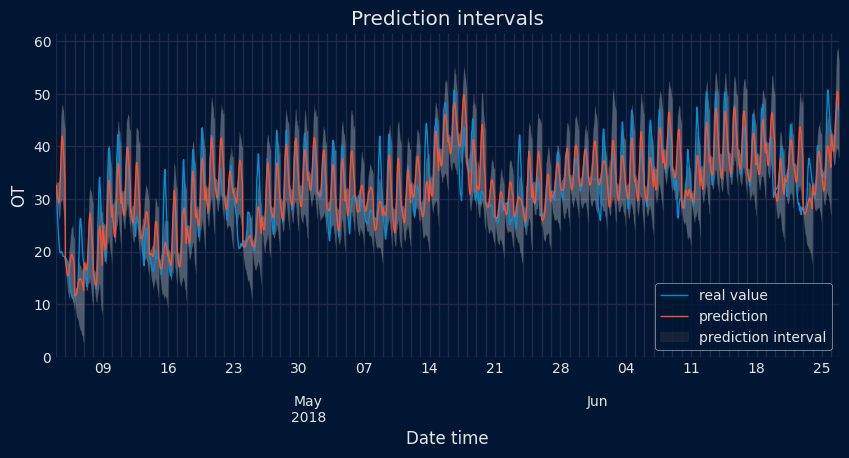

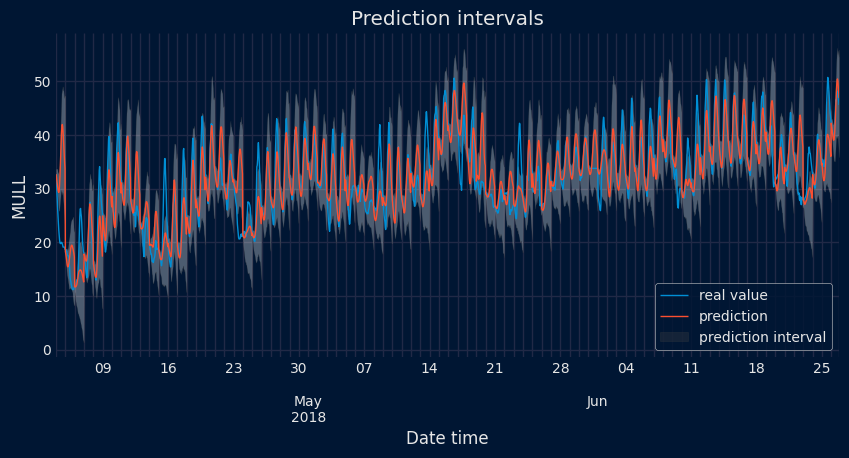

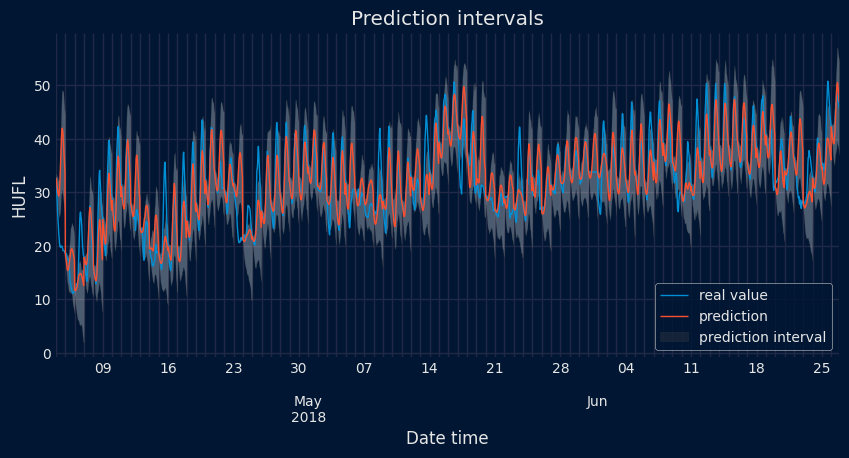

In [17]:
for level in predictions['level'].unique():
    print(f"\nLevel: {level}")
    predictions_level = predictions[predictions['level'] == level].drop(columns='level').copy()
    
    # Plot intervals
    plt.rcParams['lines.linewidth'] = 1
    fig, ax = plt.subplots(figsize=(9, 4))
    plot_prediction_intervals(
        predictions     = predictions_level,
        y_true          = data_test[[level]],
        target_variable = level,
        initial_x_zoom  = None,
        title           = "Prediction intervals",
        xaxis_title     = "Date time",
        yaxis_title     = level,
        ax              = ax
    )
    fill_between_obj = ax.collections[0]
    fill_between_obj.set_facecolor('white')
    fill_between_obj.set_alpha(0.3)

    # Predicted interval coverage (on test data)
    coverage = calculate_coverage(
        y_true      = data_test[level],
        lower_bound = predictions_level["lower_bound"], 
        upper_bound = predictions_level["upper_bound"]
    )
    print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

    # Area of the interval
    area = (predictions_level["upper_bound"] - predictions_level["lower_bound"]).sum()
    print(f"Area of the interval: {round(area, 2)}")

    metric

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff9100;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
<b>Probabilistic forecasting in production</b>

The correct estimation of prediction intervals with conformal methods depends on the residuals being representative of future errors. For this reason, calibration residuals should be used. However, the dynamics of the series and models can change over time, so it is important to monitor and regularly update the residuals. It can be done easily using the <code>set_out_sample_residuals()</code> method.
</p>

</div>